In [1]:
import numpy as np
from astropy.io import fits
from astropy import stats, units as u
import os 
from tqdm import tqdm
from astropy.table import QTable, hstack, Column
import matplotlib.pyplot as plt

In [2]:
# Define names and filenames...
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/'

In [3]:
def get_files(endswith, root_dir): 

    file_list = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(endswith):
                print(os.path.join(root, file))
                file_list += [os.path.join(root, file)]

    print('TOTAL NUMBER OF FILES:', len(file_list))
    return(file_list)

files_maps = get_files('_hst_ha.fits', root_dir)
files_errmaps_ = get_files('_hst_ha_err.fits', root_dir)
files_nebs_ = get_files('_nebmask.fits', root_dir)

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc3627/hst_contsub/ngc3627_hst_ha.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1512/hst_contsub/ngc1512_hst_ha.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1433/hst_contsub/ngc1433_hst_ha.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc5068/hst_contsub/ngc5068_hst_ha.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4321/hst_contsub/ngc4321_hst_ha.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1365n/hst_contsub/ngc1365n_hst_ha.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc4303/hst_contsub/ngc4303_hst_ha.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1087/hst_contsub/ngc1087_hst_ha.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc7496/hst_contsub/ngc7496_hst_ha.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc1385/hst_contsu

In [4]:
files_nebs = []
files_errmaps = []

for file_maps in files_maps: 

    for file_nebs in files_nebs_: 
        if file_maps.split(root_dir)[-1].split('/')[0] == file_nebs.split(root_dir)[-1].split('/')[0]:
            
            # if 'ngc628e' in file_maps.split(root_dir)[-1].split('/')[0]: 
            #      print('Removed:', file_maps)
            #      files_maps.remove(file_maps)
            #      continue

            if file_maps.split('/')[-1].split('_')[0].lower() != file_nebs.split('/')[-1].split('_')[0].lower():
                print('ERROR: MISMATCHED FILE NAMES')
                print(file_maps.split('/')[-1], file_nebs.split('/')[-1])
            files_nebs += [file_nebs]
            break

    for file_errmaps in files_errmaps_: 
            if file_maps.split(root_dir)[-1].split('/')[0] == file_errmaps.split(root_dir)[-1].split('/')[0]:
                
                # if 'ngc628e' in file_maps.split(root_dir)[-1].split('/')[0]: 
                #     continue

                if file_maps.split('/')[-1].split('_')[0].lower() != file_errmaps.split('/')[-1].split('_')[0].lower():
                    print('ERROR: MISMATCHED FILE NAMES')
                    print(file_maps.split('/')[-1], file_nebs.split('/')[-1])
                files_errmaps += [file_errmaps]
                break

ERROR: MISMATCHED FILE NAMES
ngc1365n_hst_ha.fits NGC1365_nebmask.fits
ERROR: MISMATCHED FILE NAMES
ngc2835s_hst_ha.fits NGC2835_nebmask.fits
ERROR: MISMATCHED FILE NAMES
ngc628e_hst_ha.fits NGC0628_nebmask.fits
ERROR: MISMATCHED FILE NAMES
ngc628c_hst_ha.fits NGC0628_nebmask.fits


In [5]:
def get_stats(data): 

    data = data[~np.isnan(data)]
    data = data[data!=0]
    data = data[np.isfinite(data)]

    mean = np.nanmean(data)
    median = np.nanmedian(data)
    p = np.nanpercentile(data, [5, 16, 84, 95])
    std = stats.mad_std(data, ignore_nan=True) 
    return([mean, median, p[0], p[1], p[2], p[3], std])

gals  = []
output_stats = []
output_stats_dict = []

for i in tqdm(range(len(files_maps)), desc='Loading files...'): 
# for i in tqdm(range(1), desc='Loading files...'): 

    file_maps, file_errmaps = files_maps[i], files_errmaps[i]

    # Loading files...
    hstha_hdu = fits.open(file_maps)[0]
    # muscat_hdu = fits.open(file_nebs)[0]
    hsthaerr_hdu = fits.open(file_errmaps)[0]

    factor = 1e3
    pix_size_hst = (hstha_hdu.header['CD1_1']*u.deg).to('arcsec')
    pix_area_hst = pix_size_hst**2

    data_map = hstha_hdu.data / pix_area_hst.value / factor
    data_err = hsthaerr_hdu.data / pix_area_hst.value / factor

    # Get RMS for whole map... 
    stats_map = get_stats(data_map)
    stats_err = get_stats(data_err)

    gal = file_maps.split('/')[-1].split('_hst_ha.fits')[0].upper()
    gals += [gal]

    output_stats += [[stats_map+stats_err]]
    output_stats_dict += [{'galaxy': gal, 'stats_map': stats_map, 'stats_err': stats_err}]

gals = np.array(gals, dtype='<U12')
output_stats = np.array(output_stats)

gals

Loading files...: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


array(['NGC3627', 'NGC1512', 'NGC1433', 'NGC5068', 'NGC4321', 'NGC1365N',
       'NGC4303', 'NGC1087', 'NGC7496', 'NGC1385', 'NGC2835S', 'IC5332',
       'NGC628E', 'NGC3351', 'NGC3351', 'NGC628C', 'NGC1672', 'NGC1672',
       'NGC1300', 'NGC1566'], dtype='<U12')

In [6]:
# Get into a astropy table the output of the stats of the maps to .tex

gal_names = gals.copy()
for i, gal in enumerate(gal_names):
    gal = gal.upper()
    if 'NGC' in gal:
        gal_split = gal.split('NGC')
        gal = 'NGC~' + gal_split[1]
    if 'IC' in gal:
        gal_split = gal.split('IC')
        gal = 'IC~' + gal_split[1]
        
    if '628C' in gal:
        gal_split = gal.split('628C')
        gal = gal_split[0] + '0628-C'
    if '628E' in gal:
        gal_split = gal.split('628E')
        gal = gal_split[0] + '0628-E'

    gal_names[i] = gal

names=('mean_map', 'median_map', 'p5_map', 'p16_map', 'p84_map', 'p95_map', 'std_map', 
        'mean_noise', 'median_noise', 'p5_noise', 'p16_noise', 'p84_noise', 'p95_noise', 'std_noise')

table1 = Column(gal_names, name='gal_name')
table2 = QTable(np.array(output_stats)[:,0,:], names=names)

table = hstack([table1, table2])
table.sort('gal_name')
table

gal_name,mean_map,median_map,p5_map,p16_map,p84_map,p95_map,std_map,mean_noise,median_noise,p5_noise,p16_noise,p84_noise,p95_noise,std_noise
str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
IC~5332,6.4729509353637695,3.994248628616333,-92.4085723876953,-54.11777847290039,64.59275726318357,108.00419464111323,59.33405818127885,96.17059326171875,90.66572570800781,82.12077331542969,85.38286590576172,99.34161956787109,115.15444259643553,6.105678354733348
NGC~0628-C,15.42284107208252,8.955242156982422,-31.355109214782715,-15.34320644378662,36.875778350830075,64.24543762207031,25.582076636759023,43.29901885986328,41.38722229003906,36.73973846435547,38.48590087890625,46.1959342956543,55.09734630584714,3.3980787679132343
NGC~0628-E,5.898143291473389,3.2905375957489014,-99.31277923583984,-58.2789338684082,67.63361358642578,114.7477355957031,62.82079536737939,117.28544616699219,110.26544952392578,99.82295989990234,103.86821746826172,121.45892303466796,144.91954498291014,7.361940314508656
NGC~1087,18.3931884765625,9.894195556640625,-92.06616973876953,-51.800968170166016,77.81095733642577,136.16302490234375,64.1742331973572,115.00575256347656,105.54147338867188,93.83871536254883,97.96430847167969,119.75524200439453,139.33233642578125,9.449858505312756
NGC~1300,4.011474132537842,2.4184114933013916,-22.426856994628906,-12.440816040039063,18.173275527954104,30.663663673400876,15.201931106887681,44.094970703125,42.16624069213867,37.6434440612793,39.3363037109375,46.28318786621094,54.175689697265625,3.2627100999294862
NGC~1365N,29.80211639404297,13.855974197387695,-79.46312637329102,-42.32561050415039,76.29807495117186,134.87031326293942,58.49574521650379,117.82318115234375,108.12521362304688,95.7332992553711,99.98017883300781,125.05338287353516,150.30242919921864,10.246935917204192
NGC~1385,18.627878189086914,7.96279239654541,-93.67354583740234,-53.3858642578125,75.98724517822266,138.36033630371094,63.857775355353326,118.35205078125,109.19511413574219,97.03836593627929,101.4424673461914,124.98561096191406,148.59371337890622,9.552418581570006
NGC~1433,13.964106559753418,3.92915678024292,-92.38762817382812,-53.77096176147461,64.6673812866211,110.44908142089844,59.04915902602448,144.3595428466797,133.06829833984375,117.10315704345703,122.99349975585938,151.75521850585938,180.78761291503906,12.358076324458732
NGC~1512,5.263856887817383,2.273226499557495,-102.450679397583,-60.24683090209961,67.23372833251953,114.45955238342282,63.62579638502998,90.37742614746094,82.2137680053711,73.61360931396484,76.86310577392578,91.52347564697266,108.85171966552733,6.229775255209613


In [7]:
formats={
        'gal_name': '%s',
        'mean_map': '%.1f',
        'median_map': '%.1f',
        'p5_map': '%.1f',
        'p16_map': '%.1f',
        'p84_map': '%.1f',
        'p95_map': '%.1f',
        'std_map': '%.1f',
        'mean_noise': '%.1f',
        'median_noise': '%.1f',
        'p5_noise': '%.1f',
        'p16_noise': '%.1f',
        'p84_noise': '%.1f',
        'p95_noise': '%.1f',
        'std_noise': '%.1f'
        }

table.write('./tabs/galmap_props.tex', formats=formats, overwrite=True)

In [8]:
# Reorganise to match names in .fits files
gals = table['gal_name']

for i, gal in enumerate(gals):
    if '~' in gal:
        gal_split = gal.split('~')
        gal = gal_split[0] + gal_split[1]
    table['gal_name'][i] = gal

table.write('./tabs/galmap_props.fits', overwrite=True)
table

gal_name,mean_map,median_map,p5_map,p16_map,p84_map,p95_map,std_map,mean_noise,median_noise,p5_noise,p16_noise,p84_noise,p95_noise,std_noise
str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
IC5332,6.4729509353637695,3.994248628616333,-92.4085723876953,-54.11777847290039,64.59275726318357,108.00419464111323,59.33405818127885,96.17059326171875,90.66572570800781,82.12077331542969,85.38286590576172,99.34161956787109,115.15444259643553,6.105678354733348
NGC0628-C,15.42284107208252,8.955242156982422,-31.355109214782715,-15.34320644378662,36.875778350830075,64.24543762207031,25.582076636759023,43.29901885986328,41.38722229003906,36.73973846435547,38.48590087890625,46.1959342956543,55.09734630584714,3.3980787679132343
NGC0628-E,5.898143291473389,3.2905375957489014,-99.31277923583984,-58.2789338684082,67.63361358642578,114.7477355957031,62.82079536737939,117.28544616699219,110.26544952392578,99.82295989990234,103.86821746826172,121.45892303466796,144.91954498291014,7.361940314508656
NGC1087,18.3931884765625,9.894195556640625,-92.06616973876953,-51.800968170166016,77.81095733642577,136.16302490234375,64.1742331973572,115.00575256347656,105.54147338867188,93.83871536254883,97.96430847167969,119.75524200439453,139.33233642578125,9.449858505312756
NGC1300,4.011474132537842,2.4184114933013916,-22.426856994628906,-12.440816040039063,18.173275527954104,30.663663673400876,15.201931106887681,44.094970703125,42.16624069213867,37.6434440612793,39.3363037109375,46.28318786621094,54.175689697265625,3.2627100999294862
NGC1365N,29.80211639404297,13.855974197387695,-79.46312637329102,-42.32561050415039,76.29807495117186,134.87031326293942,58.49574521650379,117.82318115234375,108.12521362304688,95.7332992553711,99.98017883300781,125.05338287353516,150.30242919921864,10.246935917204192
NGC1385,18.627878189086914,7.96279239654541,-93.67354583740234,-53.3858642578125,75.98724517822266,138.36033630371094,63.857775355353326,118.35205078125,109.19511413574219,97.03836593627929,101.4424673461914,124.98561096191406,148.59371337890622,9.552418581570006
NGC1433,13.964106559753418,3.92915678024292,-92.38762817382812,-53.77096176147461,64.6673812866211,110.44908142089844,59.04915902602448,144.3595428466797,133.06829833984375,117.10315704345703,122.99349975585938,151.75521850585938,180.78761291503906,12.358076324458732
NGC1512,5.263856887817383,2.273226499557495,-102.450679397583,-60.24683090209961,67.23372833251953,114.45955238342282,63.62579638502998,90.37742614746094,82.2137680053711,73.61360931396484,76.86310577392578,91.52347564697266,108.85171966552733,6.229775255209613


In [9]:
def get_hist(data, bins='', nbins=50, logbins=False, norm=True, cum=False):

    """Get histogram

    Parameters
    ----------
    data : np.array
        input data
    bins : list
        input bin edges for histogram calculaiton; default=''
    nbins : int
        number of bins to determine if bins is not given; defult=50
    logbins : bool
        logarithmically spaced bins if bins is not given
    norm : bool
        normalise such that max is equal to unity; default=True
    cum : bool
        cumulative distorbution; otherwise probability distorbution
    Returns
    -------
    bins : list
        bin edges for histogram calculaiton
    bin_cent : np.array
        bin centres, for easy plotting in matplotlib
    hist : np.array
        histogram data for each bin centre
    """
    
    data = data.flatten()

    if bins.all() is None:
        vmin=np.nanmin(data)
        vmax=np.nanmax(data)

        bmin = vmin - (np.absolute(vmin)*1)
        bmax = vmax + (np.absolute(vmax)*0.3)

        if logbins:
            min = np.nanmin(data[data>0])
            bins = np.logspace(np.log10(bmin), np.log10(bmax), nbins+1)
        else:
            bins = np.linspace(bmin, bmax, nbins+1)
    else:
        nbins = len(bins)-1

    bins_cent = np.empty([nbins])

    for i in range(nbins):
        bins_cent[i] = np.nanmean([bins[i], bins[i+1]])

    hist = np.histogram(data.flatten(), bins)[0]

    if cum:
        hist = np.cumsum(hist)
    if norm:
        hist = hist/np.nanmax(hist)

    return(bins, bins_cent, hist)

In [10]:
# for i in tqdm(range(len(files_maps)), desc='Loading files...'): 
for i in [0]: 

    file_maps, file_errmaps = files_maps[i], files_errmaps[i]

    # Loading files...
    hstha_hdu = fits.open(file_maps)[0]
    hsthaerr_hdu = fits.open(file_errmaps)[0]

    factor = 1e3
    pix_size_hst = (hstha_hdu.header['CD1_1']*u.deg).to('arcsec')
    pix_area_hst = pix_size_hst**2

    data_map = hstha_hdu.data / pix_area_hst.value / factor
    data_err = hsthaerr_hdu.data / pix_area_hst.value / factor

    # # Get RMS for whole map... 
    stats_map = get_stats(data_map)
    stats_err = get_stats(data_err)

    bins = np.linspace(-300, 300, 100)
    bins, bins_cent, hist = get_hist(data_map, bins)

In [11]:
err_mean = stats_err[0]
map_std = stats_map[-1]
map_mean = stats_map[1]

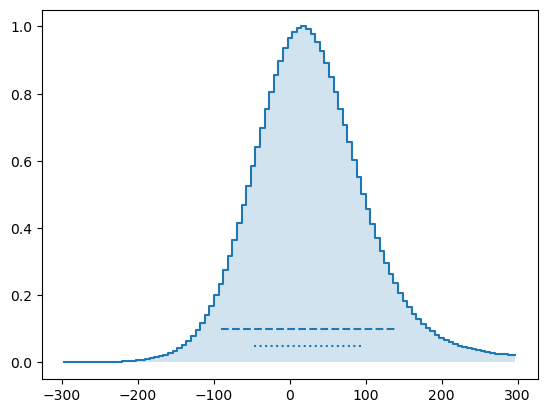

In [12]:
color = f'C{i}'
plt.plot(bins_cent, hist, ds='steps-mid', c=color)
plt.fill_between(bins_cent, hist, y2=0, step="mid", alpha=0.2, zorder=0, fc=color, ec='none')

# plt.plot(stats_map[0], 0, 'ro')
plt.plot([map_mean-err_mean, map_mean+err_mean], [0.1, 0.1], c=color, ls='--')
plt.plot([map_mean-map_std, map_mean+map_std], [0.05, 0.05], c=color, ls=':')